In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

       m	-0.178	1.322
       n	2.205	0.971
M的平均值
-0.17761922619047707
M的標準差
1.3196862765281396
N的平均值
2.205396702380951
N的標準差
0.9692140248869402
high的最大值
169.949997
high的最小值
119.660004
high的最大值的日期
[Row(date=datetime.date(2016, 12, 13))]
high的最小值的日期
[Row(date=datetime.date(2016, 2, 11))]
比high平均值小的10個值
[Row(high=119.660004), Row(high=121.050003), Row(high=122.830002), Row(high=123.089996), Row(high=123.370003), Row(high=123.610001), Row(high=123.989998), Row(high=124.139999), Row(high=124.230003), Row(high=124.739998)]
比high平均值大的10個值
[Row(high=169.949997), Row(high=169.889999), Row(high=169.850006), Row(high=169.110001), Row(high=168.25), Row(high=168.229996), Row(high=167.979996), Row(high=167.940002), Row(high=167.740005), Row(high=167.490005)]
比high平均值小的10個值的日期
[Row(date=datetime.date(2016, 2, 11)), Row(date=datetime.date(2016, 2, 12)), Row(date=datetime.date(2016, 1, 28)), Row(date=datetime.date(2016, 2, 16)), Row(date=datetime.date(2016, 1, 27)), Row(date=datetime.date(2016, 1, 26))

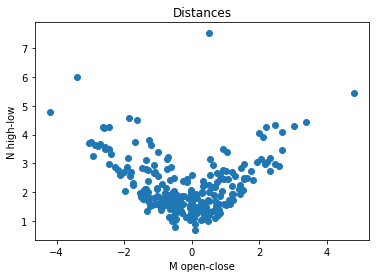

In [3]:
# -*- coding: utf-8 -*-

import os
import matplotlib.pylab as plt
import math
import numpy
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *


class Utils():
    def __init__(self):
        pass

    # 敘述性統計：平均數 標準差
    def getStatValue(self, df, fieldName):
        stat = df.select(avg(fieldName), stddev(fieldName)).collect()
        return stat[0]
#新增m欄位
def m_fun(open,close):
    return open-close
#新增n欄位
def n_fun(high,low):
    return high-low
    
class LoadSavedData(Utils):
    # 繼承
    def __init__(self):
        Utils.__init__(self)

    # 載入資料集檔案
    def loadData(self, dataFile):
        sql = 'SELECT * FROM parquet.`%s`' % dataFile
        df = sqlContext.sql(sql)
        return df

    # 列印敘述性統計
    def printStats(self, df, fields=None):
        if fields is None:
            df.describe().show()
        else:
            for field in fields:
                df.describe(field).show()

    # 繪製散佈圖

    def plotScatter(self, df, x, y, title=None, xLabel=None, yLabel=None):
        # 轉換為 Pandas 資料格式
        pdf = df.toPandas()

        plt.scatter(pdf[[x]], pdf[[y]])

        if title is not None:
            plt.title(title)

        if title is not None:
            plt.title(title)

        if xLabel is not None:
            plt.xlabel(xLabel)

        if yLabel is not None:
            plt.ylabel(yLabel)

        plt.show()



# 主程式
def main(dataDir):
    # 資料欄位名稱
    fields = ['date', 'open', 'high', 'low', 'close','volumn','adjclose']
    
    # 類別初始化
    worker = LoadSavedData()

    # 載入資料集
    df = worker.loadData(dataFile='%s/IBM.parquet' % dataDir)

    # 自訂函數：對照轉換欄位相應值
    my_m = udf(m_fun, DoubleType())
    my_n = udf(n_fun, DoubleType())

    # 對照轉換欄位相應值，衍生新欄位，取代原資料集
    #新增mn欄位
    df = df.withColumn('m', my_m('open', 'close')).withColumn('n', my_n('high', 'low'))

    # 列印資料集綱要
    #df.printSchema() 列印出檔案資料結構
    #df.show() 秀出整張表
    # 列印敘述性統計：平均數 標準差
    for field in ['m', 'n']:
        stat = worker.getStatValue(df, field)
        print('%8s\t%.3f\t%.3f' % (field, stat[0], stat[1]))
    m = numpy.array(df.select('m').collect())
    n = numpy.array(df.select('n').collect())
    high = numpy.array(df.select('high').collect())
    date = numpy.array(df.select('date').collect())

    m_mean = m.mean()
    m_std = m.std()
    # 用numpy計算平均值mean() 標準差std()
    n_mean = n.mean()
    n_std = n.std()
    high_mean = high.mean()
    high_max = high.max()
    high_min = high.min()
    date_high_max = df.select("date") \
                  .where(col("high")==high_max) \
                  .collect()
    date_high_min = df.select("date") \
                  .where(col("high")==high_min) \
                  .collect()
    #比high平均低的10個值
    high_up = df.select("high") \
                     .where(col("high")<high_mean) \
                     .sort("high") \
                     .limit(10) \
                     .collect()
    #比high平均高的10個值
    high_down = df.select("high") \
                     .where(col("high")>high_mean) \
                     .sort(desc("high")) \
                     .limit(10) \
                     .collect()
    #比high平均低的10個值
    date_high_up = df.select("date") \
                     .where(col("high")<high_mean) \
                     .sort("high") \
                     .limit(10) \
                     .collect()
    #比high平均高的10個值
    date_high_down = df.select("date") \
                     .where(col("high")>high_mean) \
                     .sort(desc("high")) \
                     .limit(10) \
                     .collect()
    
    print("M的平均值")
    print(m_mean)
    print("M的標準差")
    print(m_std)
    print("N的平均值")
    print(n_mean)
    print("N的標準差")
    print(n_std)
    print("="*50)
    print("high的最大值")
    print(high_max)
    print("high的最小值")
    print(high_min)
    print("high的最大值的日期")
    print(date_high_max)
    print("high的最小值的日期")
    print(date_high_min)
    print("="*50)
    print("比high平均值小的10個值")
    print(high_up)
    print("比high平均值大的10個值")
    print(high_down)
    print("比high平均值小的10個值的日期")
    print(date_high_up)
    print("比high平均值大的10個值的日期")
    print(date_high_down)
    

    # 繪製散佈圖
    worker.plotScatter(df, title='Distances',
                            x='m', xLabel='M open-close',
                            y='n', yLabel='N high-low')

    # 保存資料集至指定目錄下
    df.write.mode('overwrite').save('%s/IBM2.parquet' % dataDir,
                                        format='parquet')

# 程式進入點
if __name__ == '__main__':
    global sc, sqlContext

    # 本地資源運算
    appName = 'Cup-02'
    master = 'local'

    #sc = SparkContext(conf=SparkConf().setAppName(appName).setMaster(master))

    # 取得資料庫介面
    sqlContext = SQLContext(sc)

    # 調用主程式
    homeDir = os.environ['HOME']
    dirName = 'Data'
    sampleDir = '%s/Sample' % homeDir
    dataDir = '%s/Data' % homeDir

    main(dataDir)
